In [3]:
%matplotlib inline
from importlib import reload
import scipy.sparse as sp
from scipy import stats
import numpy as np
from time import time
from tqdm import tqdm_notebook, tnrange
from matplotlib import gridspec
import sys
sys.path.append('../../')
import gc
import matplotlib.pyplot as plt
import qradient
from qradient.physical_components import Gates, State
from qradient.circuit_logic import McClean
from qradient import optimization
reload(qradient.optimization)
reload(qradient.circuit_logic)
reload(qradient.physical_components)
p = np.pi

In [4]:
qnum, lnum = 3, 10
# construct observable
x = np.full(qnum, 1.)
zz = np.full([qnum, qnum], None)
for i in range(qnum-1):
    zz[i, i+1] = 1.
observable = {'x': x, 'zz': zz}

# construct circuit
crct = qradient.circuit_logic.McClean(qnum, observable, lnum)
eigvals, eigvecs = sp.linalg.eigsh(crct.observable_mat, k=2, which='SA')

# construct optimizer
opt_info = {'name': 'GradientDescent'}
opt = optimization.McCleanOpt(crct, opt_info)

def plot_costs(costs):
    for cost in costs:
        plt.plot(cost)
    plt.plot([0, steps], [m, m], '--')
    plt.ylim(ymin = m-.5)

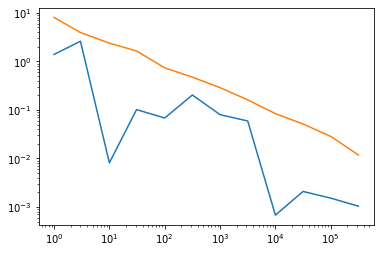

In [32]:
# TEST that sample grad yields the correct values in the limit of infinit shots
e, g = crct.grad_run()
sample_errors_e = []
sample_errors_g = []
sample_errors_g_obs = []
shot_numbers = (10**np.arange(0., 6., .5)).astype('int')
for i in tnrange(len(shot_numbers)):
    s = shot_numbers[i]
    sample_e, sample_g = crct.sample_grad(shot_num=s)
    sample_errors_e.append(np.abs(sample_e - e))
    sample_errors_g.append(np.linalg.norm((sample_g - g).flatten()))
plt.plot(shot_numbers, sample_errors_e)
plt.plot(shot_numbers, sample_errors_g)
plt.loglog()
plt.show()

In [40]:
costs = []
opt_info = {'name': 'GradientDescent'}
opt.reset(optimizer=opt_info)
steps, m = 500, eigvals[0]
for _ in tnrange(steps):
    opt.step()
costs.append(opt.cost_history[:steps])
    
opt_info = {'name': 'Adam', 'step_size': .1}
opt.reset(optimizer=opt_info)
for _ in tnrange(steps):
    opt.step()
costs.append(opt.cost_history[:steps])
 
step_sizes = [.01]
for s in step_sizes:
    opt_info = {'name': 'GradientDescent', 'step_size': s}#, 'beta1': .9}
    opt.reset(optimizer=opt_info)
    for _ in tnrange(steps):
        opt.step(grad_method='sample_grad', shot_num=5)
    costs.append(opt.cost_history[:steps])

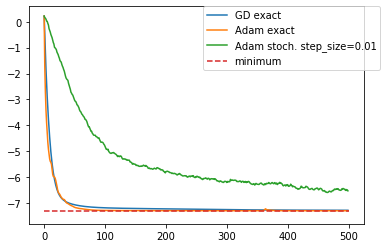

In [41]:
legend = ['GD exact', 'Adam exact']
for s in step_sizes:
    legend.append('Adam stoch. step_size=' + str(s))
legend.append('minimum')

plot_costs(costs)
plt.legend(legend, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()